# Data exploration

Questions to ask: 

1. How do values distribute for the main variable *search_interest*?
1. What are keywords with high search interest? 
2. What is the average search interest ...
    1. for a keyword?
    1. for a keyword that has at least 1 entry > 0?
    1. for a keyword that has at least 1 entry > 50?
    1. for a keyword that has at least 1 entry == 100?
3. How is search interest ...
    1. correlated with positive or negative ESG classification?
    1. correlated and distributed across industries?
    1. correlated and distributed across ESG classificatoin (positive/negative)?

In [1]:
import seaborn as sns 
sns.set_context('talk')
sns.set_style('whitegrid')

import pandas as pd
import numpy as np
import boto3
import s3fs

import matplotlib.pyplot as plt
%matplotlib inline

# import helper_functions.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data')
import helper_functions as h

# set configuration
conf = {'region_name': 'us-west-2', 
        'bucket_name': 'esg-analytics', 
        'input_prefix': 'raw/', 
        'output_prefix': 'processed/',
        'select_files': ['20201017-191627gtrends_preprocessed.csv', 
                         '20201017-191627gtrends_metadata.csv'], 
       'export_files':['search_interest', 
                       'search_interest_meta',
                      'missing_search_interest']}

s3 = boto3.resource('s3')
bucket = s3.Bucket('esg-analytics')

# load files with .csv format from output_prefix
load_files= []
for obj in bucket.objects.filter(Prefix=conf['output_prefix']): 
    if obj.key.split('.')[-1] == 'csv':
        load_files.append(obj.key)

print('LOAD FILES\n'+'-'*40, *load_files, sep='\n')

df_missing = pd.read_csv(f"s3://{conf['bucket_name']}/{load_files[0]}")#, names=['keyword'])
df = pd.read_csv(f"s3://{conf['bucket_name']}/{load_files[1]}")#, names=['date', 'keyword', 'search_interest'])
df_meta = pd.read_csv(f"s3://{conf['bucket_name']}/{load_files[2]}") #, names=[]

## Merge of the API query and its metadata

Each row in `metadata` (*df_meta*) contains a keyword. In contrast, each row in `gtrends` (*df*) contains search interest per week for a keyword which repeats across dates. Thus, we have to populate `metadata` as many times as there are unique dates for each keyword which is $261$.

In [33]:
def join_query_meta(df_query, df_meta, id_col):
    """Left join of df_query on df_meta, where df_meta is the input to the query
    
    :param df_query: pandas DataFrame with query results
    :param df_meta: pandas DataFrame with input data for query
    :param id_col: string that specifies the identifying column common to both dataframes
    :return : DataFrame of joined datasets
    """
    # take id as index for both
    df_query_idcol = df_query.set_index(id_col)
    df_meta_idcol = df_meta.set_index(id_col)
    
    # join query and meta
    df_joined = df_query_idcol.join(df_meta_idcol, on=id_col, how='left').reset_index()
    
    return df_joined

df_all = join_query_meta(df_query=df, df_meta=df_meta, id_col='keyword')

h.make_csv(df_all, 'merged_gtrends_meta.csv', '../data/processed', header=True)

# check correct storage
df = pd.read_csv('../data/processed/merged_gtrends_meta.csv')

Path created: ../data/processed/merged_gtrends_meta.csv


## Distribution of search_interest

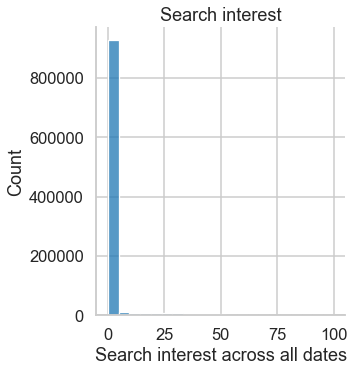

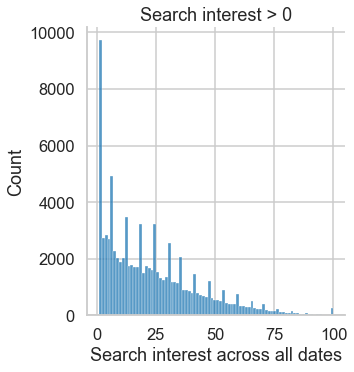

In [54]:
g = sns.displot(df.search_interest)
ax = g.axes.flatten()[0]
ax.set_title('Search interest')
ax.set_xlabel('Search interest across all dates')
plt.show()

g = sns.displot(df.search_interest[df.search_interest > 0])
ax = g.axes.flatten()[0]
ax.set_title('Search interest > 0')
ax.set_xlabel('Search interest across all dates')
plt.show()

In [55]:
avg_search_interest = df.search_interest.mean()
median_search_interest = df.search_interest.median()

print("Search interest")
print('-'*40)
print(f'Average: {avg_search_interest} \nMedian: {median_search_interest}')

Search interest
----------------------------------------
Average: 2.0464317732201436 
Median: 0.0


## Keywords and firms with highest search interest

highest average per keyword 

In [56]:
top_n = 10
print(f"{top_n} highest average search interest per keyword:\n",\
      df.groupby("keyword").mean().search_interest.sort_values(ascending=False)[:top_n]
     )

10 highest average search interest per keyword:
 keyword
green Apple                    69.199234
bad Amazon                     67.122605
best AutoZone                  65.885057
bad AutoZone                   63.452107
best Apache                    63.306513
green Amazon                   62.597701
best Adobe                     61.931034
best American International    59.168582
best American Airlines         58.823755
best Alphabet                  57.425287
Name: search_interest, dtype: float64


Most searched firms

In [57]:
print(f"{top_n} highest average search interest per firm:\n",\
      df.groupby('firm_name_processed').search_interest.mean().sort_values(ascending=False)[:top_n]
     )

10 highest average search interest per firm:
 firm_name_processed
Amazon                    12.642735
Apple                     12.283584
Adobe                     10.741527
Alphabet                   7.824698
Apache                     7.238786
American Express           6.327203
American International     5.946999
American Airlines          5.571353
AutoZone                   5.376009
AT&T                       4.540996
Name: search_interest, dtype: float64


Search interest == 100 across whole timespan

In [58]:
print("How often search interest reached maximum across the whole timespan:\n"
    ,df[df.search_interest == 100].keyword.value_counts()[:5])

How often search interest reached maximum across the whole timespan:
 problem Analog Devices         3
leader Apache                  2
tax Amcor                      2
bad Advance Auto Parts         2
best American International    2
Name: keyword, dtype: int64


What has been search most recently?

In [59]:
date_recent = df.date.tail().values
print("Recent average search activity\n", '-'*40)

print("What keywords have been searched recently from {} to {}:".format(date_recent[0], date_recent[-1]))

print(df[df.date.isin(date_recent)]\
    .groupby('keyword')\
    .search_interest\
    .mean()\
    .sort_values(ascending=False)[:top_n])

print('-'*40)

print("Which firms have been searched recently from {} to {}:".format(date_recent[0], date_recent[-1]))
print(df[df.date.isin(date_recent)]\
    .groupby('firm_name_processed')\
    .search_interest\
    .mean()\
    .sort_values(ascending=False)[:top_n])

Recent average search activity
 ----------------------------------------
What keywords have been searched recently from 2020-09-13 to 2020-10-11:
keyword
green Apple             88.6
bad Amazon              82.2
improve Apple           76.0
green Alphabet          74.8
bad American Express    73.0
best Alphabet           72.6
green Amazon            71.0
fraud Amazon            70.6
best AutoZone           69.0
breach Apple            68.0
Name: search_interest, dtype: float64
----------------------------------------
Which firms have been searched recently from 2020-09-13 to 2020-10-11:
firm_name_processed
Apple                     16.255385
Amazon                    15.169231
Alphabet                  10.384615
Adobe                      9.821538
Apache                     7.212308
American International     6.996667
American Express           6.476923
AutoZone                   5.058462
3M                         4.643077
Applied Materials          4.184615
Name: search_interest, dty

## Correlation

In [60]:
print("correlation between search interest and ESG classification (positive=1/negative=0)")
print(round(df.corr().loc['search_interest','positive'], 3))

correlation between search interest and ESG classification (positive=1/negative=0)
0.056
